In [1]:
import scipy as sci
import scipy.special as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cmath
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math, random
import mpl_toolkits.mplot3d
import numpy as np
%matplotlib inline

def db(x):
    return 20*np.log10(abs(x))

# Spherical Harmonics

The Spherical Harmonics are defined as

\begin{equation}
Y_n^m \equiv \sqrt{\frac{2n+1}{4\pi}\frac{(n-m)!}{(n+m)!}}P_n^m(\cos\theta)e^{jm\phi},
\end{equation}
where $P_n^m(\cdot)$ are the associated Legendre functions, $m \in \mathbb{Z}$ is the degree and $n \in \mathbb{N}$ is the order.

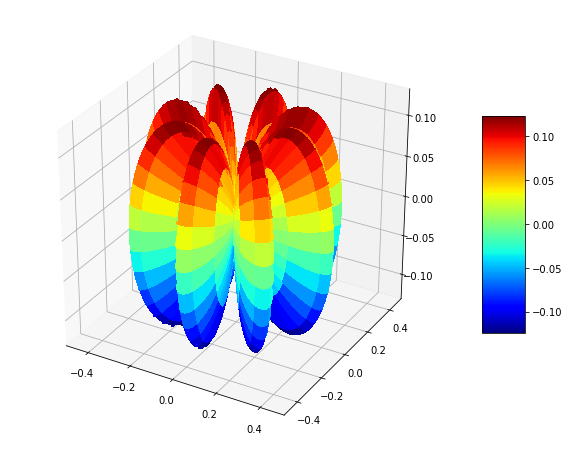

In [2]:
m = 4
n = 4
    
phi, theta = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
r = sp.sph_harm(m, n, phi, theta).real #Plot the real part of the Spherical Harmonics
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
surf = ax.plot_surface(x, y, z, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Spherical Fourier Transform

A function $f(\theta, \phi)$ that is part of the Hilbert space can be represented as a weighted sum of spherical harmonics

\begin{equation}
f(\theta, \phi) = \sum_{n=0}^{\infty}\sum_{m=-n}^{n}f_{nm}Y_{n}^{m},
\label{eq.iSHT}
\end{equation}
where $f_{nm}$ are the Spherical Fourier Transform coefficient of $f(\theta, \phi)$ such as

\begin{equation}
f_{nm} = \int_0^{2\pi}\int_0^{\pi}f(\theta, \phi)[Y_n^m(\theta, \phi)]^*\sin\theta \, d\theta \, d\phi.
\label{eq.SHT}
\end{equation}

$f_{nm}$ and $f(\theta, \phi)$ are, respectively, the Spherical Fourier Transform (SFT) and its inverse.

# Plane wave

Assume a plane wave of constant frequency arriving from $(\theta_s, \phi_s)$, the sound pressure it causes at $\textbf{r} = (r, \theta, \phi)$ can be described as

\begin{equation}
p(k, r, \theta, \phi) = \sum_{n=0}^{\infty}\sum_{m=-n}^{n}4\pi j^n j_n(kr)[Y_n^m(\theta_s, \phi_s)]^*Y_n^m(\theta, \phi),
\end{equation}
where $j_n(x) = (-1)^nx^n\Big({\frac{1}{x}\frac{d}{dx}}\Big)^n\frac{\sin x}{x}$ is the spherical Bessel function. When dealing with plane waves from diferent directions and/or amplitudes, $p(k, r, \theta, \phi)$ is written as

\begin{equation}
p(k, r, \theta, \phi) = \sum_{s=1}^{S}\sum_{n=0}^{\infty}\sum_{m=-n}^{n}4\pi j^n j_n(kr)a_s(k)[Y_n^m(\theta_s, \phi_s)]^*Y_n^m(\theta, \phi),
\label{eq.pressao_amp}
\end{equation}
$a_s(k)$ is the amplitude seen from the origin and $(\theta_s, \phi_s)$, $s = 1, \dots, S$, is the direction of arrival from each wave. In practice, the infinit sum is truncated at $N$.

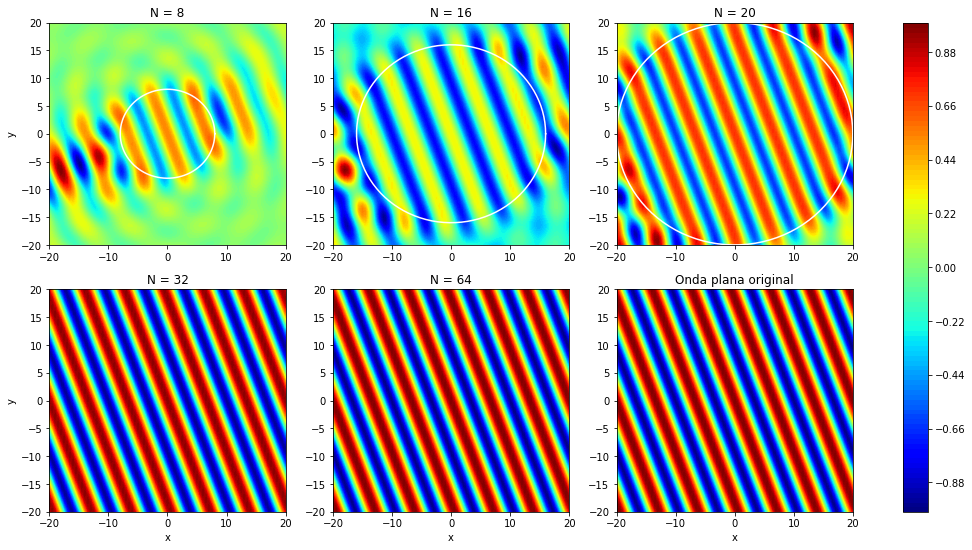

In [6]:
#Example of a single plane wave with wave number k = 1 arriving from (90º,20º) for N = 8, 16, 20, 32, 64
theta_s = np.pi/2 #90º
phi_s = np.pi/9 #20º

#Area of reconstruction
x, y = np.meshgrid(np.arange(-20, 20+0.5, 0.5), np.arange(-20, 20+0.5, 0.5))
z = np.arange(0, 2*np.pi+2*np.pi/80, 2*np.pi/80)

r = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, x)
theta = np.arccos(z/np.sqrt(x**2 + y**2 + z**2))

p = np.zeros((x.shape[0],y.shape[0], 6), dtype=complex)
k = 1
kx = k*np.sin(theta_s)*np.cos(phi_s)
ky = k*np.sin(theta_s)*np.sin(phi_s)
kz = k*np.cos(theta_s)

#Original Plane Wave in (x,y,z)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        aux = kx*x[i][j] + ky*y[i][j] + kz*z[i]
        p[i][j][0] = np.exp(-1j*aux)
        
N = np.array([8, 16, 20, 32, 64])

for a in range(N.shape[0]):
    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            sum_out = 0
            for n in range(np.int(N[a]+1)):
                sum_in = 0
                for m in range(-n,n+1):
                    sum_in = sum_in + 4*np.pi*(1j**n)*sp.spherical_jn(n, k*r[i][j])*np.conj(sp.sph_harm(m, n, phi_s, theta_s))*sp.sph_harm(m, n, phi[i][j], theta[i][j])

                sum_out = sum_out + sum_in

            p[i][j][a+1] = sum_out

#A circle is ploted to visualize how the area of reconstructed is related to N
ang = np.linspace(0, 2*np.pi, 100)

fig, axs = plt.subplots(2,3,figsize=(18,9))
pcm = axs[0,0].contourf(x, y, p[:,:,1].real, 100, cmap='jet')
axs[0,0].plot(N[0]*np.cos(ang), N[0]*np.sin(ang), 'w')
axs[0, 0].set_title('N = 8')
axs[0, 0].set_ylabel('y')

pcm = axs[0,1].contourf(x, y, p[:,:,2].real, 100, cmap='jet')
axs[0,1].plot(N[1]*np.cos(ang), N[1]*np.sin(ang), 'w')
axs[0,1].set_title('N = 16')

pcm = axs[0,2].contourf(x, y, p[:,:,3].real, 100, cmap='jet')
axs[0,2].plot(N[2]*np.cos(ang), N[2]*np.sin(ang), 'w')
axs[0,2].set_title('N = 20')

pcm = axs[1,0].contourf(x, y, p[:,:,4].real, 100, cmap='jet')
axs[1,0].set_title('N = 32')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')

pcm = axs[1,1].contourf(x, y, p[:,:,5].real, 100, cmap='jet')
axs[1,1].set_title('N = 64')
axs[1,1].set_xlabel('x')

pcm = axs[1,2].contourf(x, y, p[:,:,0].real,100, cmap='jet')
axs[1,2].set_title('Original Plane Wave')
axs[1,2].set_xlabel('x')

fig.colorbar(pcm, ax=axs[:,:])
plt.show()

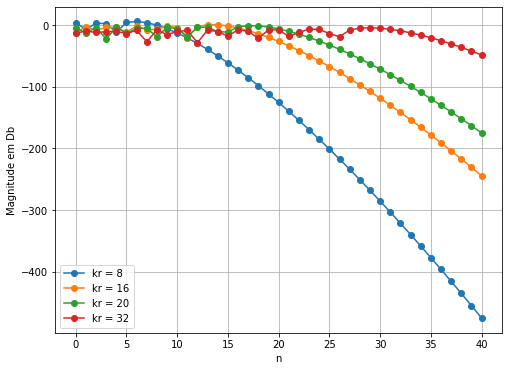

In [9]:
#For n > kr, |4\pi j^n j_n(kr)| -> 0
kr = np.array([8, 16, 20, 32])
n = np.arange(0, 41, 1)
mag = np.zeros((n.shape[0],kr.shape[0]))

for k in range(kr.shape[0]):
    for i in range(n.shape[0]):
        mag[i][k] = db(4*np.pi*1j**(n[i])*sp.spherical_jn(n[i], kr[k]))
    
plt.figure(figsize=(8,6))
plt.plot(n,mag,'-o')
plt.legend(('kr = 8', 'kr = 16', 'kr = 20', 'kr = 32'), loc='lower left')
plt.ylabel('Magnitude in Db')
plt.xlabel('n')
plt.grid(True)
plt.show()

It is possible to find the sound pressure at any other position $(r', \theta', \phi')$:

\begin{equation}
p(k,r',\theta',\phi') = \sum_{n=0}^{\infty}\sum_{m=-n}^{n}\frac{j_n(kr')}{j_n(kr)}p_{nm}(k,r)Y_{n}^m(\theta',\phi').
\end{equation}

The effects of the division by $j_n(kr_a)$ is shown below.

C:\Users\Fernanda Caldas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


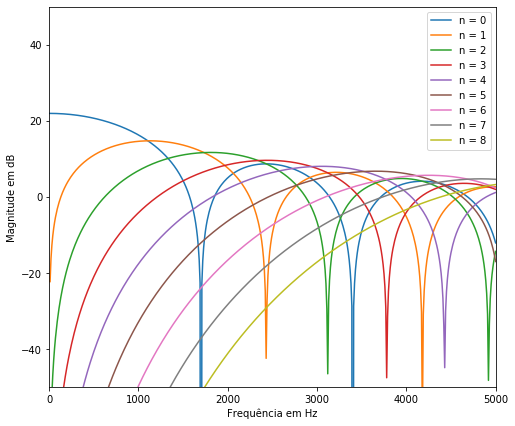

In [11]:
r = 0.1
f = np.arange(0, 5010, 10)
c = 340
k = 2*np.pi*f/c

n = np.arange(0, 9, 1)
Rdb = np.zeros((f.shape[0], n.shape[0]))

for i in range(Rdb.shape[0]):
    for j in range(n.shape[0]):
        rn = 4*np.pi*((1j)**n[j])*sp.spherical_jn(n[j], k[i]*r)
        Rdb[i][j] = db(rn)
        
plt.figure(figsize=(8,7))
for i in range(n.shape[0]):
    plt.plot(f, Rdb[:,i])
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.ylabel('Magnitude in dB')
plt.xlabel('Frequency in Hz')
plt.legend(('n = 0', 'n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5', 'n = 6', 'n = 7', 'n = 8'),loc='upper right')

# Sampling by an rigid spherical array of microphones

The sound pressure around a rigid sphere is
\begin{equation}
    p(k, r, \theta, \phi) = \sum_{n=0}^{\infty}\sum_{-n}^{n}a_{nm}(k)R_n(kr, kr_a)Y_n^m(\theta, \phi)
\end{equation}
where

\begin{equation}
    R_n(kr, kr_a) = 4\pi j^n\bigg[j_n(kr) - \frac{j_n^{'}(kr_a)}{h_n^{(2)'}(kr_a)}h_n^{(2)}(kr) \bigg].
\end{equation}
The first term of $R_n(kr, kr_a)$ describes the plane wave and its second term describes the scattering effect caused by the rigid sphere. $h_n^{(2)}(x) = j(-1)^nx^n\Big({\frac{1}{x}\frac{d}{dx}}\Big)^n\frac{e^{-jx}}{x}$ is the spherical Hankel function of second kind.

In [3]:
#Spherical Hankel function of second kind
def hn2(n, x, derivative):
    if derivative:
        h = sp.spherical_jn(n, x, derivative=True) - 1j*sp.spherical_yn(n, x, derivative=True)
    else:
        h = sp.spherical_jn(n, x) - 1j*sp.spherical_yn(n, x)
    
    return h

def Rn(n, kr, kr_a):
    rn = 4*np.pi*((1j)**n)*(sp.spherical_jn(n, kr) - hn2(n, kr, derivative=False)*sp.spherical_jn(n, kr_a, derivative=True)/hn2(n, kr_a, derivative=True))
    
    return rn

C:\Users\Fernanda Caldas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in cdouble_scalars
  # This is added back by InteractiveShellApp.init_path()


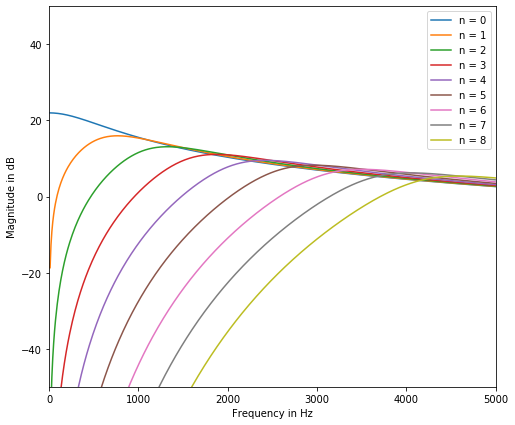

In [2]:
r_a = 0.1
f = np.arange(0, 5010, 10)
c = 340
k = 2*np.pi*f/c

n = np.arange(0, 9, 1)
Rdb = np.zeros((f.shape[0], n.shape[0]))

for i in range(Rdb.shape[0]):
    for j in range(n.shape[0]):
        rn = Rn(n[j], k[i]*r_a, k[i]*r_a)
        Rdb[i][j] = db(rn)
        
plt.figure(figsize=(8,7))
for i in range(n.shape[0]):
    plt.plot(f, Rdb[:,i])
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.ylabel('Magnitude in dB')
plt.xlabel('Frequency in Hz')
plt.legend(('n = 0', 'n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5', 'n = 6', 'n = 7', 'n = 8'),loc='upper right')

In [47]:
def Rn2(N, kr, kr_a):
    jn_1 = np.zeros((kr.shape[0],kr.shape[1]), dtype='complex')
    hn2_1 = np.zeros((kr.shape[0],kr.shape[1]), dtype='complex')
    jn_2 = np.zeros((kr_a.shape[0]), dtype='complex')
    hn2_2 = np.zeros((kr_a.shape[0]), dtype='complex')
    rn = np.zeros((N+1, kr.shape[0], kr.shape[1], kr_a.shape[0]), dtype='complex')
    
    for n in range(N+1):
        for i in range(kr.shape[0]):
            for j in range(kr.shape[0]):
                jn_1[i][j] = sp.spherical_jn(n, kr[i][j])
                hn2_1[i][j] =  hn2(n, kr[i][j], derivative=False)
          
        for k in range(kr_a.shape[0]):
            jn_2[k] = sp.spherical_jn(n, kr_a[k], derivative=True)
            hn2_2[k] = hn2(n, kr_a[k], derivative=True)

        for i in range(kr.shape[0]):
            for j in range(kr.shape[1]):
                for k in range(kr_a.shape[0]):
                    rn[n][i][j][k] = 4*np.pi*((1j)**n)*(jn_1[i][j]-hn2_1[i][j]*jn_2[k]/hn2_2[k])
    
    return rn

def pressure(N, rn, Y, a_s, Y_s):
    p = np.zeros((Y.shape[0], Y.shape[1], rn.shape[3]), dtype=complex)
    
    for r_a in range(rn.shape[3]):
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                sum_n = 0
                
                for n in range(N+1):
                    sum_m = 0
                    R = rn[n][i][j][r_a]
                        
                    for m in range(2*n+1):
                        sum_s = a_s*np.conj(Y_s[n][m])

                        sum_m = sum_m + sum_s*R*Y[i][j][n][m]

                    sum_n = sum_n + sum_m

                p[i][j][r_a] = sum_n
        
    return p

def harm(N, theta, phi):
    I = theta.shape[0]
    J = theta.shape[1]
    Y = np.zeros((I, J, N+1, (2*N+1)+1), dtype='complex')
    
    for i in range(I):
        for j in range(J):
            for n in range(N+1):
                for m in range(2*n+1):
                    Y[i][j][n][m] = sp.sph_harm(m-n, n, phi[i][j], theta[i][j])

    return Y

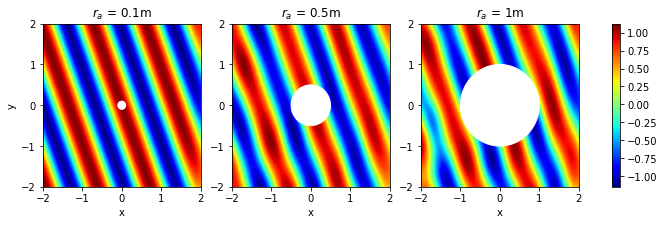

In [50]:
x, y = np.meshgrid(np.arange(-2, 2+0.01, 0.01), np.arange(-2, 2+0.01, 0.01))
z = np.arange(0, 2*np.pi+2*np.pi/400, 2*np.pi/400)
r = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, x)
theta = np.arccos(z/np.sqrt(x**2 + y**2 + z**2))

k = 5
N = 32
a_s = 1
Y_l = harm(N, theta, phi)
theta_s = np.pi/2 #90º
phi_s = np.pi/9 #20º
Y_s = np.zeros((N+1, (2*N+1)+1), dtype='complex')
for n in range(N+1):
    for m in range(2*n+1):
        Y_s[n][m] = sp.sph_harm(m-n, n, phi_s, theta_s)

r_a = np.array([0.1, 0.5, 1])
rn = Rn2(N, k*r, k*r_a)
p = pressure(N, rn, Y_l, a_s, Y_s)

fig, axs = plt.subplots(1,3,figsize=(12,3))
pcm = axs[0].contourf(x, y, p[:,:,0].real,100, cmap='jet')
c1 = plt.Circle((0, 0), 0.1, color='w')
axs[0].add_patch(c1)
axs[0].set_title('$r_a$ = 0.1m')
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].set_xticks([-2, -1, 0, 1, 2])
axs[0].set_yticks([-2, -1, 0, 1, 2])

pcm = axs[1].contourf(x, y, p[:,:,1].real, 100, cmap='jet')
c2 = plt.Circle((0, 0), 0.5, color='w')
axs[1].add_patch(c2)
axs[1].set_title('$r_a$ = 0.5m')
axs[1].set_xlabel('x')
axs[1].set_xticks([-2, -1, 0, 1, 2])
axs[1].set_yticks([-2, -1, 0, 1, 2])

pcm = axs[2].contourf(x, y, p[:,:,2].real, 100, cmap='jet')
c3 = plt.Circle((0, 0), 1, color='w')
axs[2].add_patch(c3)
axs[2].set_title('$r_a$ = 1m')
axs[2].set_xlabel('x')
axs[2].set_xticks([-2, -1, 0, 1, 2])
axs[2].set_yticks([-2, -1, 0, 1, 2])

fig.colorbar(pcm, ax=axs[:])
plt.show()

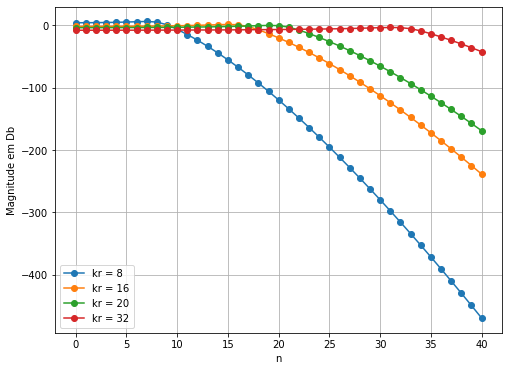

In [28]:
kr = np.array([8, 16, 20, 32])
n = np.arange(0, 41, 1)
mag = np.zeros((n.shape[0],kr.shape[0]))

for k in range(kr.shape[0]):
    for i in range(n.shape[0]):
        mag[i][k] = 20*np.log10(np.absolute(Rn(n[i], kr[k], kr[k])))
    
plt.figure(figsize=(8,6))
plt.plot(n,mag,'-o')
plt.legend(('kr = 8', 'kr = 16', 'kr = 20', 'kr = 32'), loc='lower left')
plt.ylabel('Magnitude in Db')
plt.xlabel('n')
plt.grid(True)
plt.show()

# Spherical Fourier Transform (SFT) of the Rigid Array

\begin{equation}
\begin{aligned}
p_{nm}(k, r_a) &= \int_0^{2\pi}\int_0^{\pi}p(k, r_a, \theta, \phi)[Y_n^m(\theta, \phi)]^*\sin\theta \,d\theta \,d\phi\\
&\approx \frac{4\pi}{Q}\sum_{q=1}^{Q}p(k, r_a, \theta_q, \phi_q)[Y_n^m(\theta_q, \phi_q)]^*.
\end{aligned}
\end{equation}
This approximation is valid for nearly-uniform ditribuition of the microphones at the array.

In [3]:
#p_nm Spherical Fourier Transform coefficients of the sound pressure
def fourier(p, Y):
    N = Y.shape[1] - 1
    Q = p.shape[0]
    pnm = np.zeros((N+1, (2*N+1)+1), dtype='complex')
    
    for n in range(N+1):
        for m in range(2*n+1):
            sum_q = 0

            for q in range(Q):
                sum_q = sum_q + p[q][0]*np.conjugate(Y[q][n][m])

            pnm[n][m] = (4*np.pi/Q)*sum_q
        
    return pnm